In [6]:
!kaggle datasets download -d splcher/animefacedataset


  0%|          | 0.00/395M [00:00<?, ?B/s]
  1%|          | 2.00M/395M [00:00<00:26, 15.7MB/s]
  1%|1         | 5.00M/395M [00:00<00:39, 10.4MB/s]
  2%|2         | 9.00M/395M [00:02<01:10, 5.74MB/s]
  3%|3         | 12.0M/395M [00:02<00:53, 7.50MB/s]
  4%|3         | 14.0M/395M [00:02<00:44, 8.98MB/s]
  4%|4         | 16.0M/395M [00:02<00:38, 10.2MB/s]
  5%|4         | 18.0M/395M [00:03<00:53, 7.36MB/s]
  5%|5         | 21.0M/395M [00:03<00:42, 9.28MB/s]
  6%|5         | 23.0M/395M [00:03<00:36, 10.6MB/s]
  6%|6         | 25.0M/395M [00:04<01:18, 4.95MB/s]
  7%|7         | 28.0M/395M [00:04<00:58, 6.55MB/s]
  8%|7         | 30.0M/395M [00:04<00:47, 7.98MB/s]
  8%|8         | 32.0M/395M [00:04<00:40, 9.43MB/s]
  9%|8         | 34.0M/395M [00:05<00:55, 6.79MB/s]
  9%|9         | 36.0M/395M [00:05<00:47, 7.93MB/s]
 10%|9         | 39.0M/395M [00:05<00:37, 10.0MB/s]
 10%|#         | 41.0M/395M [00:06<01:13, 5.02MB/s]
 11%|#1        | 44.0M/395M [00:06<00:55, 6.64MB/s]
 12%|#1        | 46.

In [ ]:
import zipfile
with zipfile.ZipFile('./animefacedataset.zip') as zipdata:
    zipdata.extractall('./datasets')

In [1]:
import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir='datasets/animefaces/'

In [3]:
img_size=64
stats=((0.5,0.5,0.5),(0.5,0.5,0.5))   #normalizes every channel between -1 to 1
tfms=T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [4]:
train_ds=ImageFolder(data_dir,transform=tfms)

In [5]:
batch_size=128
dl=DataLoader(train_ds,batch_size,pin_memory=True,num_workers=3,shuffle=True)

In [6]:
def denorm(imgs):
    return imgs*stats[1][0]+stats[0][0]

In [7]:
def showbatch(b):
    img,_=b
    plt.figure(figsize=(10,10))
    plt.imshow(make_grid(denorm(img),nrow=16).permute(1,2,0))
    plt.axis('off')
    plt.show()
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

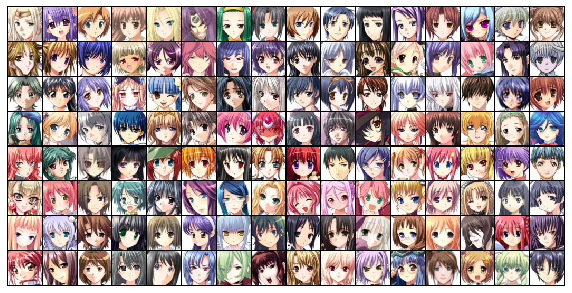

In [8]:
for b in dl:
    showbatch(b)
    break

In [9]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader:
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [10]:
device

device(type='cuda')

In [11]:
ddl=DeviceDataLoader(dl,device)

### Discriminator Network
The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [12]:
discriminator=nn.Sequential(
    #in:64x64x3
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True), #param:negative slope
    #out:32x32x64
    
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    #out:16x16x128
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    #out:8x8x256
    
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    #out:4x4x512
    
    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #out:1x1x1
    
    nn.Flatten(),
    nn.Sigmoid()
)
#NOTE: LeakyRelu helps us to retain the significance of negative weights.

In [13]:
discriminator=to_device(discriminator,device)

### Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution)

<img src='https://github.com/aqeelanwar/conv_layers_animation/raw/master/gifs/transposed_conv_S2P1.gif'>

In [14]:
latent_channel_size=128

In [15]:
Generator=nn.Sequential(
    #in:1x1xlatent_channel_size
    nn.ConvTranspose2d(128,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out:4x4x512
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out:8x8x256
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out:16x16x128
    
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out:32x32x64
    
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    #out:32x32x3
    
    nn.Tanh()    #hyperbolic tangent will the vectors in the range of -1 to 1
)

In [20]:
generator=to_device(Generator,device)

In [16]:
#Creating random latent vector batch of batchsize 
xb=torch.randn(batch_size,latent_channel_size,1,1)  #random vector of given size

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


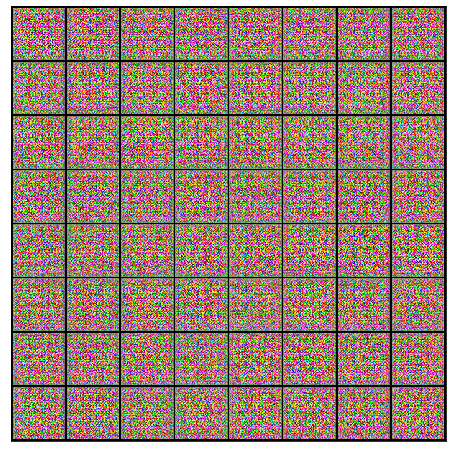

In [17]:
#lets show the generated batch
print(xb.shape)
fake_img=Generator(xb)
print(fake_img.shape)
show_images(fake_img)

## Train Discriminator

In [52]:
def train_discriminator(real_imgs,opt_d):
    #clear gradients
    opt_d.zero_grad()
    
    #training real_images
    real_preds=discriminator(real_imgs)
    real_targets=torch.ones(real_imgs.size(0),1,device=device)
    real_loss=F.binary_cross_entropy(real_preds,real_targets)
    real_score=torch.mean(real_preds).item()
    
    #create random noise vector to get fake images out of generator
    latent=torch.randn(batch_size,latent_channel_size,1,1,device=device)
    fake_imgs=generator(latent)
    
    #training discriminator
    fake_preds=discriminator(fake_imgs)
    fake_targets=torch.zeros(fake_imgs.size(0),1,device=device)
    fake_loss=F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score=torch.mean(fake_preds).item()
    
    #Update parameters
    loss=real_loss+fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(),real_score,fake_score

## Train Generator

In [51]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    #latent tensor
    latent=torch.randn(batch_size,latent_channel_size,1,1,device=device)
    fake_imgs=generator(latent)
    #getting predictions from discriminator
    preds=discriminator(fake_imgs)
    targets=torch.ones(batch_size,1,device=device) #coz targets should be 1 for fake images also
    #calculating loss
    loss=F.binary_cross_entropy(preds,targets)
    #update
    loss.backward()
    opt_g.step()
    
    return loss.item()

**Saving Samples while training**

In [22]:
from torchvision.utils import save_image
import os

In [23]:
os.makedirs('generated/animefaces')

In [1]:
sample_dir='generated/animefaces'

In [41]:
def save_samples(index,latent,show=True):
    fake_imgs=generator(latent)
    
    fake_img_name=f"anime-gans-generated-{index}.png"
    save_image(denorm(fake_imgs),os.path.join(sample_dir,fake_img_name),nrow=8)
    print(f"Saving .. {fake_img_name}")
    if show:
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.imshow(make_grid(denorm(fake_imgs).cpu().detach(),nrow=8).permute(1,2,0))

In [42]:
latent=torch.randn(64,latent_channel_size,1,1,device=device)

Saving .. anime-gans-generated-0.png


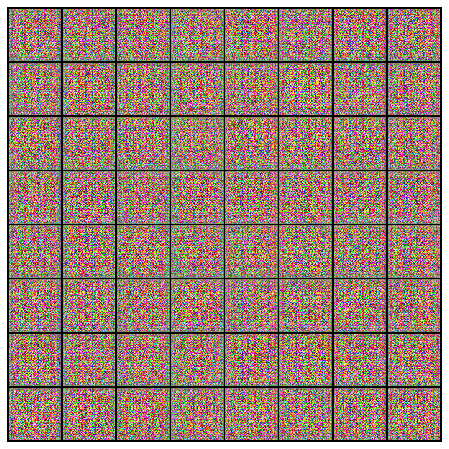

In [43]:
save_samples(0,latent)

## Full Training

In [48]:
from tqdm.notebook import tqdm     #tqdm is progress bar utility
def fit(epochs,lr,start_idx=1):
    
    torch.cuda.empty_cache()
    
    #loss and score 
    losses_g=[]
    losses_d=[]
    real_scores=[]
    fake_scores=[]
    
    #optimizers 
    opt_g=torch.optim.Adam(generator.parameters(),lr,betas=(0.5,0.999))
    opt_d=torch.optim.Adam(discriminator.parameters(),lr,betas=(0.5,0.999))
    #NOTE: Adam optimizer with these specific set of betas is suggested for this type of model
    
    for epoch in range(epochs):
        for real_imgs,_ in tqdm(ddl):
            #train discriminator
            loss_d,real_sc,fake_sc=train_discriminator(real_imgs,opt_d)
            #train generator
            loss_g=train_generator(opt_g)
    
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_sc)
        fake_scores.append(fake_sc)
        
        #log
        print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}, real_score: {real_sc:.4f}, fake_score: {fake_sc:.4f}")
        
        #save images
        save_samples(epoch+start_idx,latent,show=False)
    return losses_g,losses_d,real_scores,fake_scores

In [49]:
lr=0.0002
epochs=20

In [53]:
history=fit(epochs,lr)


Epoch [1/20], loss_g: 2.1212, loss_d: 0.9888, real_score: 0.4542, fake_score: 0.0658
Saving .. anime-gans-generated-1.png



Epoch [2/20], loss_g: 6.3071, loss_d: 0.7495, real_score: 0.8352, fake_score: 0.3680
Saving .. anime-gans-generated-2.png



Epoch [3/20], loss_g: 3.3906, loss_d: 0.5776, real_score: 0.6560, fake_score: 0.0739
Saving .. anime-gans-generated-3.png



Epoch [4/20], loss_g: 4.7148, loss_d: 0.7484, real_score: 0.6087, fake_score: 0.0323
Saving .. anime-gans-generated-4.png



Epoch [5/20], loss_g: 6.5043, loss_d: 0.9536, real_score: 0.8292, fake_score: 0.4795
Saving .. anime-gans-generated-5.png



Epoch [6/20], loss_g: 4.1150, loss_d: 0.7628, real_score: 0.5206, fake_score: 0.0139
Saving .. anime-gans-generated-6.png



Epoch [7/20], loss_g: 6.0457, loss_d: 0.4384, real_score: 0.9017, fake_score: 0.2526
Saving .. anime-gans-generated-7.png



Epoch [8/20], loss_g: 3.6559, loss_d: 0.3514, real_score: 0.7943, fake_score: 0.0907
Saving .. anime-gans-generated-8.png



Epoch [9/20], loss_g: 4.9117, loss_d: 0.2413, real_score: 0.8737, fake_score: 0.0822
Saving .. anime-gans-generated-9.png



Epoch [10/20], loss_g: 7.4998, loss_d: 0.1952, real_score: 0.8549, fake_score: 0.0068
Saving .. anime-gans-generated-10.png



Epoch [11/20], loss_g: 7.4340, loss_d: 0.2770, real_score: 0.9680, fake_score: 0.1987
Saving .. anime-gans-generated-11.png



Epoch [12/20], loss_g: 4.8600, loss_d: 0.1341, real_score: 0.9042, fake_score: 0.0250
Saving .. anime-gans-generated-12.png



Epoch [13/20], loss_g: 8.4894, loss_d: 0.6985, real_score: 0.9959, fake_score: 0.4230
Saving .. anime-gans-generated-13.png



Epoch [14/20], loss_g: 4.0900, loss_d: 0.1810, real_score: 0.9272, fake_score: 0.0923
Saving .. anime-gans-generated-14.png



Epoch [15/20], loss_g: 3.9283, loss_d: 0.2936, real_score: 0.8626, fake_score: 0.0905
Saving .. anime-gans-generated-15.png



Epoch [16/20], loss_g: 5.0826, loss_d: 0.2824, real_score: 0.9319, fake_score: 0.1737
Saving .. anime-gans-generated-16.png



Epoch [17/20], loss_g: 4.0358, loss_d: 0.1692, real_score: 0.8834, fake_score: 0.0270
Saving .. anime-gans-generated-17.png



Epoch [18/20], loss_g: 4.7039, loss_d: 0.1323, real_score: 0.9437, fake_score: 0.0583
Saving .. anime-gans-generated-18.png



Epoch [19/20], loss_g: 4.5783, loss_d: 0.2179, real_score: 0.8455, fake_score: 0.0064
Saving .. anime-gans-generated-19.png



Epoch [20/20], loss_g: 5.8672, loss_d: 0.4881, real_score: 0.7065, fake_score: 0.0056
Saving .. anime-gans-generated-20.png


In [54]:
from IPython.display import Image

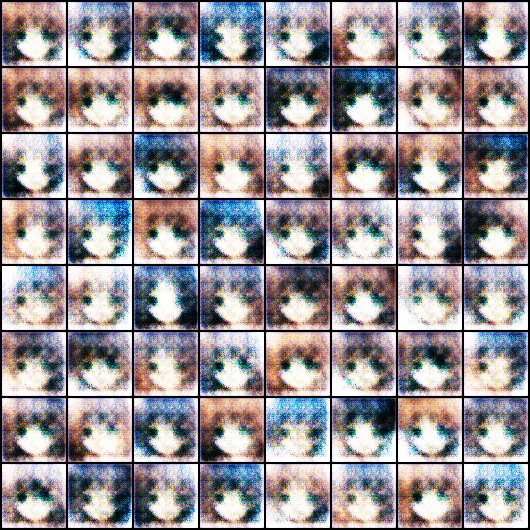

In [61]:
Image('generated/animefaces/anime-gans-generated-1.png')

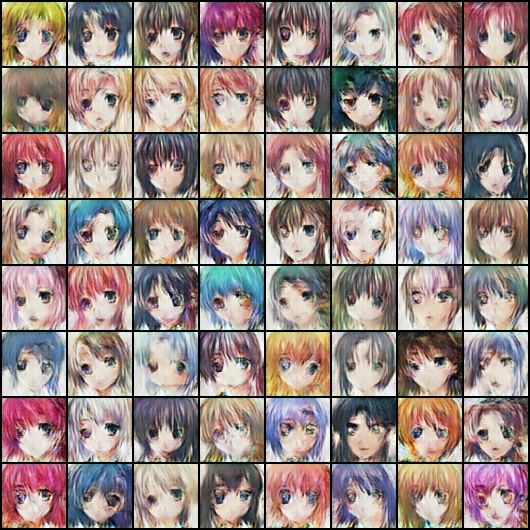

In [55]:
Image('generated/animefaces/anime-gans-generated-20.png')

In [3]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [58]:
losses_g,losses_d,real_scores,fake_scores=history

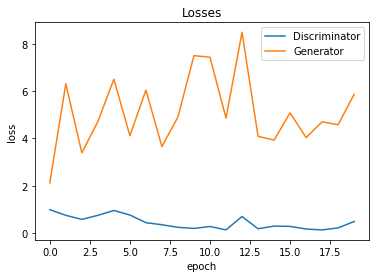

In [59]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

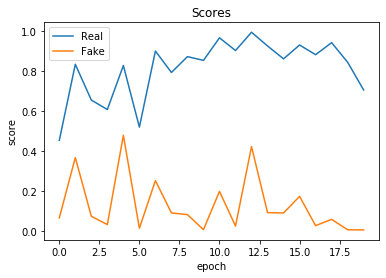

In [60]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');